# 13、IMDB情感分类LSTM与其他模型比较
通过LSTM中函数中的参数implementatio可以达到一些计算上的区别，implementation：0，1或2， 若为0，则RNN将以更少但是更大的矩阵乘法实现，因此在CPU上运行更快，但消耗更多的内存。如果设为1，则RNN将以更多但更小的矩阵乘法实现，因此在CPU上运行更慢，在GPU上运行更快，并且消耗更少的内存。如果设为2（仅LSTM和GRU可以设为2），则RNN将把输入门、遗忘门和输出门合并为单个矩阵，以获得更加在GPU上更加高效的实现。注意，RNN dropout必须在所有门上共享，并导致正则效果性能微弱降低。

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.datasets import imdb

max_features = 20000
max_length = 80
embedding_dim = 256
batch_size = 128
epochs = 10
modes = [0, 1, 2]

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = sequence.pad_sequences(X_train, max_length)
X_test = sequence.pad_sequences(X_test, max_length)

Loading data...


In [3]:
# Compile and train different models while measuring performance.
results = []
for mode in modes:
    print('Testing mode: implementation={}'.format(mode))

    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(embedding_dim,
                   dropout=0.2,
                   recurrent_dropout=0.2,
                   implementation=mode))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    start_time = time.time()
    model.summary()
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        validation_data=(X_test, y_test))
    average_time_per_epoch = (time.time() - start_time) / epochs

    results.append((history, average_time_per_epoch))

Testing mode: implementation=0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 256)           5120000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,645,569
Trainable params: 5,645,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
35s - loss: 0.4711 - acc: 0.7726 - val_loss: 0.3841 - val_acc: 0.8293
Epoch 2/10
34s - loss: 0.2980 - acc: 0.8802 - val_loss: 0.3737 - val_acc: 0.8367
Epoch 3/10
34s - loss

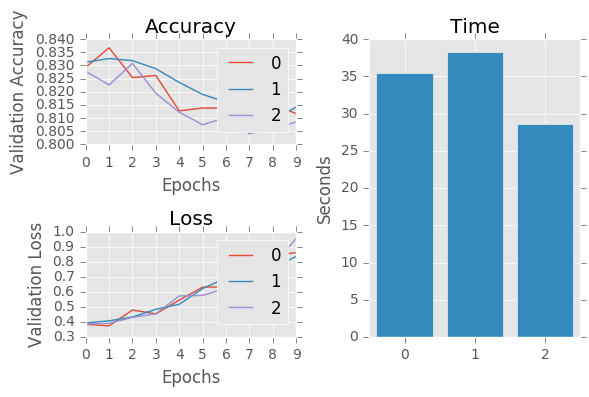

In [4]:
# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()